# Cálculo simbólico de diferentes objetos

El formalismo matemático de la relatividad general conlleva conocer el tensor de Einstein y por tanto, el tensor de Riemann y el escalar de curvatura. En métricas generales estos son muy laboriosos de obtener, "a mano" y típicamente se recurre a programas que realizan esos cálculos por nosotros. El siguiente pretende ser uno de esos programas, capaces de obtener, a partir de una métrica, los símbolos de Christoffel, el tensor de Riemann y el escalar de curvatura. Además, también será capaz de, dado un cambio de coordenadas, obtener dichos objetos.

In [4]:
import sympy as sy
sy.init_printing(use_unicode=True)

## Métrica

Definimos en primer lugar las variables de las que va a depender nuestro problema $x^{\mu}$ y posteriormente una métrica $g_{\mu\nu}$. Como primer ejemplo vamos a analizar el $\it{ansatz}$ isótropo con simetría esférica y ver si llegamos a los mismos resultados que obtuvimos en clase.

In [5]:
r, theta, R, z, phi, t = sy.symbols('r, theta, R, z, phi, t')
A = sy.Function('A')(r)
B = sy.Function('B')(r)

In [6]:
g = sy.diag(-B ,A, r**2, r**2 * sy.sin(theta)**2)
n, n = sy.shape(g)
variables = sy.Matrix([[t, r, theta, phi]])

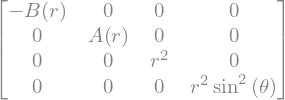

In [7]:
g

## Símbolos de Christoffel

Ahora calculamos la expresión de los Christoffel mediante:
$$\Gamma^{\alpha}_{\mu\nu}=g^{\alpha\lambda}\frac{1}{2}(g_{\lambda\nu;\mu}+g_{\mu\lambda;\nu}-g_{\mu\nu;\lambda})$$

In [8]:
def ChristoffelSimbolo(g,variables):
    n, n = sy.shape(g)
    g_inversa = g**-1
    Gamma_lista = []
    for a in range(n):
        for m in range(n):
            for v in range(n):
                s = 0
                for l in range(n):
                    g_mu = sy.diff(g[l,v], variables[m])
                    g_nu = sy.diff(g[m,l], variables[v])
                    g_lambda=sy.diff(g[m,v],variables[l])
                    G = g_inversa[a, l] * 1/2*(g_mu + g_nu - g_lambda)
                    s += G
                Gamma_lista.append(s)
    Gamma = sy.Array(Gamma_lista, (n,n,n))
    return Gamma

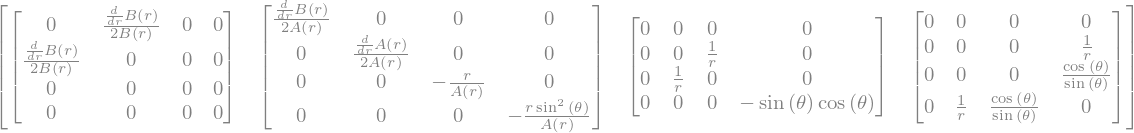

In [9]:
ChristoffelSimbolo(g, variables)

## Tensor de Riemann

Empleamos la expresión:
$$R^{\mu}_{\:\:\nu\alpha\beta}=\Gamma^{\mu}_{\nu\beta,\alpha}+\Gamma^{\mu}_{\sigma\alpha}\Gamma^{\sigma}_{\nu\beta}-\Gamma^{\mu}_{\nu\alpha,\beta}-\Gamma^{\mu}_{\sigma\beta}\Gamma^{\sigma}_{\nu\alpha}$$

In [10]:
def RiemannTensor(g, variables, Gamma=ChristoffelSimbolo(g, variables)):
    n, n=sy.shape(g)
    g_inversa = g**-1
    Riemann_lista = []
    for m in range(n):
        for v in range(n):
            for a in range(n):
                for b in range(n):
                    k = 0
                    G_a = sy.diff(Gamma[m,v,b], variables[a])
                    G_b = sy.diff(Gamma[m,v,a], variables[b])
                    for s in range(n):
                        k += Gamma[m,s,a]*Gamma[s,v,b] - Gamma[m,s,b]*Gamma[s,v,a]
                    Riemann_lista.append(sy.simplify(G_a - G_b+k))
    Riemann = sy.Array(Riemann_lista, (n,n,n,n))
    return Riemann

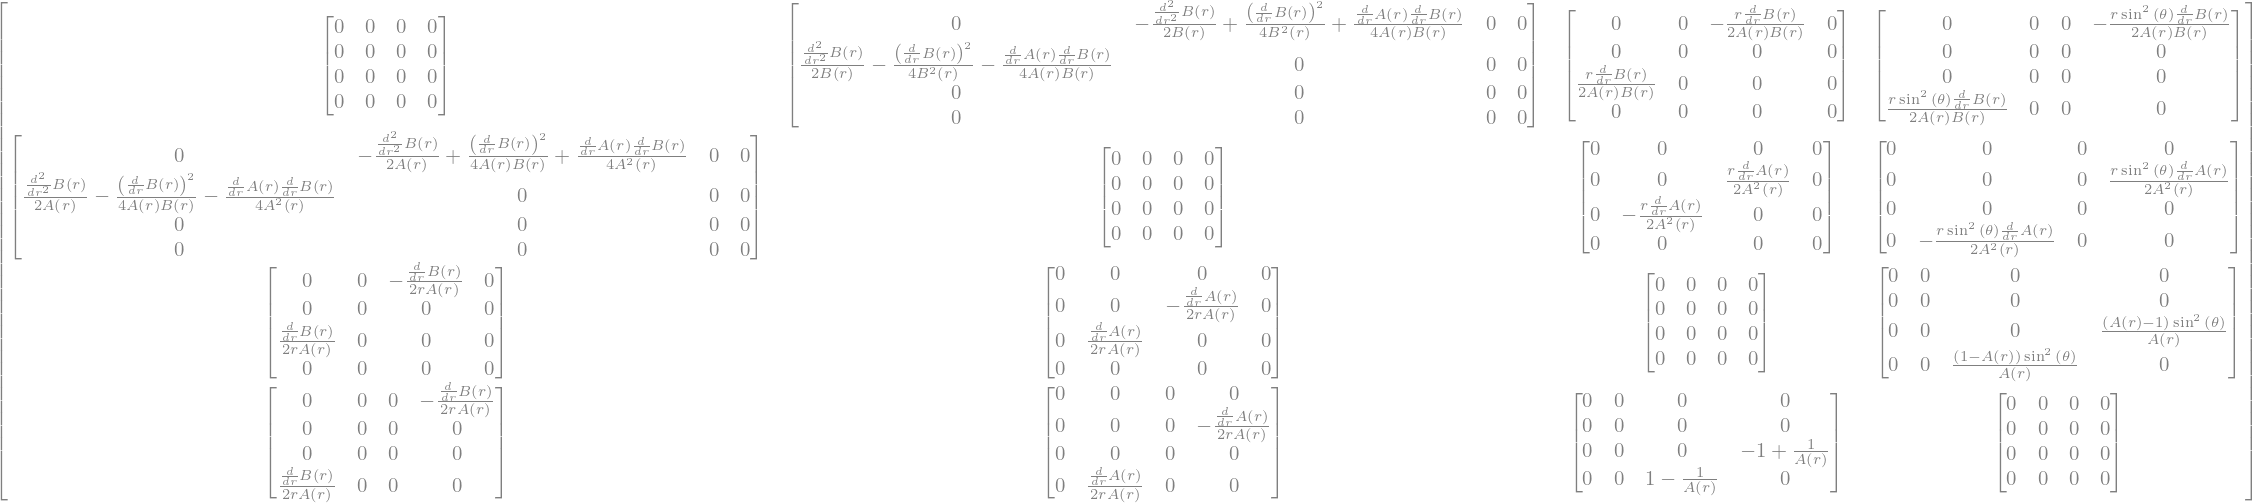

In [11]:
RiemannTensor(g, variables)

## Tensor de Ricci

El tensor de Ricci es la contracción del primer y del tercer índice del Riemann:
$$R_{\mu\nu}=R^{\lambda}_{\:\:\mu\lambda\nu}$$

In [12]:
def RicciTensor(g, variables, Riemann=RiemannTensor(g, variables)):
    n, n=sy.shape(g)
    g_inversa = g**-1
    Ricci_lista = []
    for m in range(n):
        for v in range(n):
            k = 0
            for l in range(n):
                k += Riemann[l, m, l, v]
            Ricci_lista.append(k)
    Ricci = sy.Array(Ricci_lista, (n,n))
    return Ricci

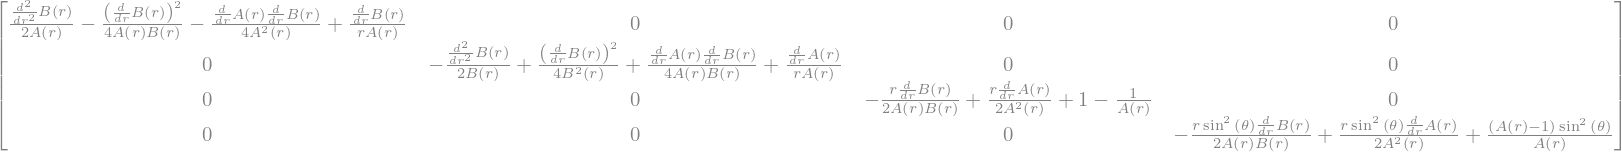

In [13]:
RicciTensor(g,variables)

## Escalar de Curvatura

Finalmente, el escalar de curvatura es la traza del Ricci:
$$R=R^{\lambda}_{\:\:\lambda}$$

In [14]:
def Escalar(g,variables, Ricci=RicciTensor(g, variables)):
    n, n = sy.shape(g)
    g_inversa = g**-1
    R_escalar = 0
    for l in range(n):
        R_escalar += g_inversa[l, l]*Ricci[l, l]
    return sy.simplify(R_escalar)

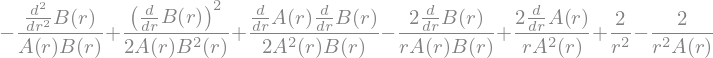

In [15]:
Escalar(g, variables)

Claramente es mucho más óptimo crear una función única que utilice los resultados que va calculando en lugar de tener que calcular todo de nuevo en cada paso. La función definitiva sería:

In [16]:
def RG(g,variables):
    Gamma = ChristoffelSimbolo(g, variables)
    Riemann = RiemannTensor(g, variables, Gamma)
    Ricci = RicciTensor(g, variables, Riemann)
    R = Escalar(g, variables, Ricci)
    return Gamma, Riemann, Ricci, R

## Cambios de coordenadas

Sean dos sistemas de coordenadas compatibles $x^{\mu}$ y $x^{\mu^{'}}$, es decir, existe una relación biyectiva entre ambas tal que uno puede obtener la relación $x^{\mu^{'}}(x)$ que además debe poder ser invertida, $x^{\mu}(x^{\mu^{'}}(x))$. Entonces podemos obtener un objeto de gran importancia:
$$\Lambda^{\mu^{'}}_{\:\:\nu}=\frac{\partial x^{\mu^{'}}}{\partial x^{\nu}}$$
Esta matriz, denominada $\textit{matriz de Jacobi}$ nos va a permitir expresar campos tensoriales en los distintos sistemas de referencia a través de la relación:
$$T^{\mu_1^{'}...\mu_p^{'}}_{\qquad\nu^{'}_1...\nu_{q}^{'}}=\Lambda^{\mu_1^{'}}_{\:\:\mu_1}...\Lambda^{\mu_p^{'}}_{\:\:\mu_p}\Lambda^{\nu_1}_{\:\:\nu_1^{'}}...\Lambda^{\nu_p}_{\:\:\nu_p^{'}}T^{\mu_1...\mu_p}_{\qquad\nu_1...\nu_{q}}$$
Tal y como hemos visto previamente el tensor métrico $g_{\mu\nu}$ encierra toda la información que necesitamos para calcular los diferentes objetos antes obtenidos luego usando la expresión anterior:
$$g_{\mu'\nu'}=g_{\mu\nu}\;\Lambda^{\mu}_{\:\:\mu'}\Lambda^{\nu}_{\:\:\nu'}$$

### Ejemplo I: Coordenadas Esféricas

Vamos a tratar de obtener la métrica en coordendas esféricas y, a partir de ella todos los objetos calculados para el $\it{ansatz}$ isótropo. Para ellos vamos a transformar la métrica euclídea.

$$g_{ij}=\delta_{j}^{i}$$

In [17]:
R, theta, phi, x, y = sy.symbols('R, theta, phi, x, y',real=True, positive=True)

In [18]:
x = R * sy.cos(phi) * sy.sin(theta)
y = R * sy.sin(phi) * sy.sin(theta)
z = R * sy.cos(theta)

In [19]:
X = sy.Matrix([x, y, z])
Y = sy.Matrix([theta, phi])

In [20]:
def RG(g,variables):
    Gamma = ChristoffelSimbolo(g, variables)
    Riemann = RiemannTensor(g, variables, Gamma)
    Ricci = RicciTensor(g, variables, Riemann)
    R = Escalar(g, variables, Ricci)
    return Gamma, Riemann, Ricci, R

In [21]:
Metrica = MetricaTransformada(X, Y, sy.diag(1,1,1))

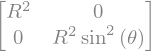

In [22]:
Metrica

A partir de aquí podemos aplicar toda la maquinaria anterior:

In [23]:
Gamma, Riemann, Ricci, R = RG(Metrica, Y)

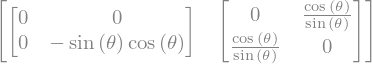

In [24]:
Gamma

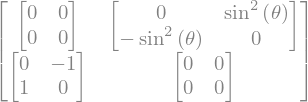

In [25]:
Riemann

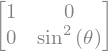

In [26]:
Ricci

In [27]:
R

## Ejemplo II: Coordenadas Elipsoidales

Si hacemos en Minkowski el cambio a coordenadas elipsoidales

In [28]:
a = sy.symbols('a')

In [29]:
x = (r**2 + a**2)**(1/2) * sy.cos(phi) * sy.sin(theta)
y = (r**2 + a**2)**(1/2) * sy.sin(phi) * sy.sin(theta)
z = r * sy.cos(theta)

In [30]:
X = sy.Matrix([t, x, y, z])
Y = sy.Matrix([t, r, theta, phi])

In [31]:
Metrica = MetricaTransformada(X, Y, sy.diag(-1,1,1,1))

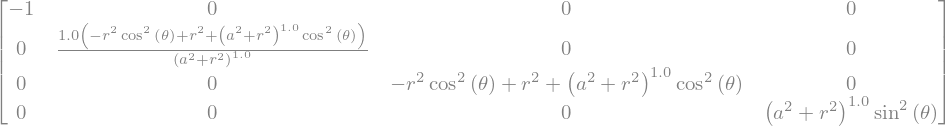

In [32]:
sy.simplify(Metrica)

Vemos que esta es justo la métrica caso límite $M\to 0$ de la métrica de Kerr (véase página 154 de las notas de clase). De modo que vemos que este programa es capaz de aplicar cambios de coordenadas diversas de forma adecuada, de hecho, vemos que el cambio es correcto, de nuevo ya que:

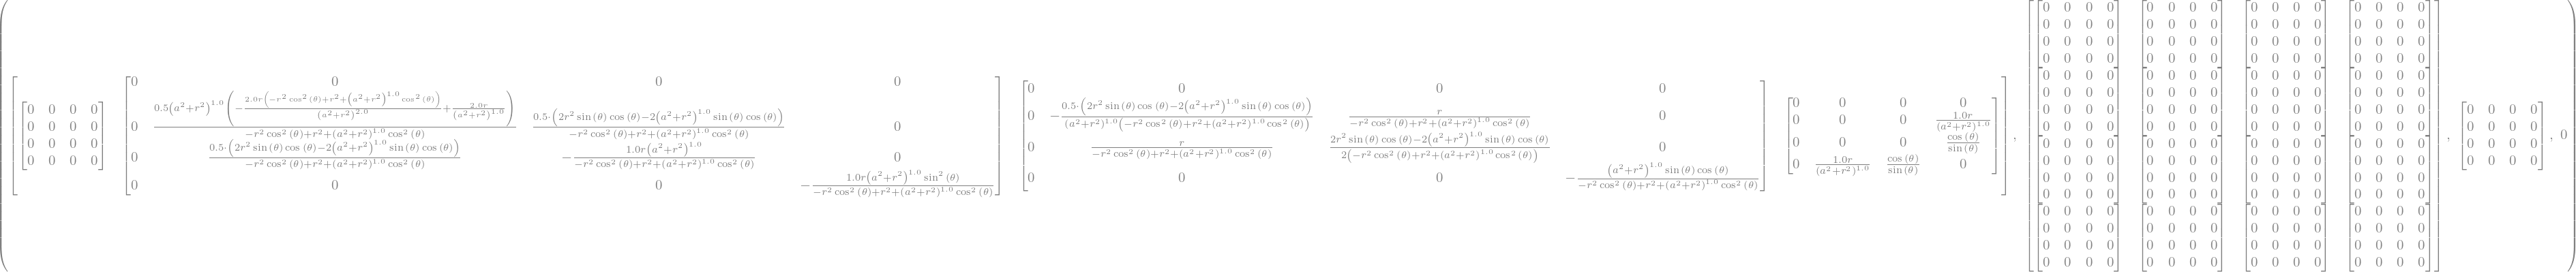

In [33]:
RG(Metrica, Y)

De modo que observamos que el Riemann y el escalar de curvatura se corresponden con un cambio de coordenadas del espacio de Minkowski.

## Métrica de Kerr

In [34]:
M = sy.symbols('M')
Delta = sy.Function('Delta')(r,theta)
Sigma = sy.Function('Sigma')(r)
Sigma = r**2 + a**2*sy.cos(theta)**2
Delta=r**2 + a**2 - 2*M*r

In [35]:
gtt = -(Delta - a**2*sy.sin(theta)**2) / Sigma
gtphi = -2*a*sy.sin(theta)**2*M*r/Sigma
gphiphi = sy.sin(theta)**2 / Sigma * ((r**2+a**2)**2 - Delta*a**2*sy.sin(theta)**2)
grr = Sigma / Delta
gthetatheta = Sigma

g_Kerr = sy.diag(gtt, grr, gthetatheta, gphiphi)
g_Kerr[0,3] = gtphi ; g_Kerr[3,0] = gtphi

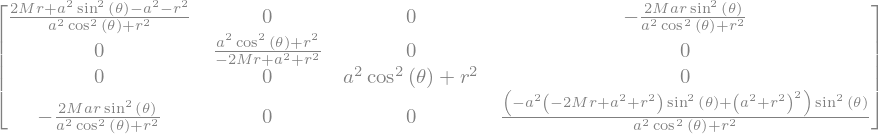

In [36]:
g_Kerr

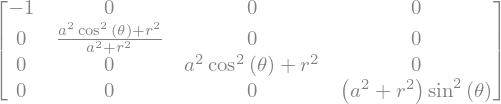

In [37]:
sy.simplify(g_Kerr.subs(M, 0))

Vemos de nuevo que el caso límite coincide con la transformación de coordenadas que hicimos antes.

In [38]:
Gamma = ChristoffelSimbolo(g_Kerr, [t, r, theta, phi])

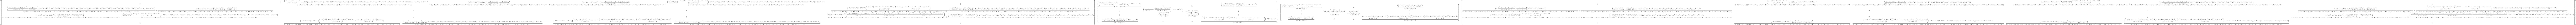

In [39]:
Gamma

El resto de objetos tardan mucho tiempo en ejecutarse aunque finalmente dan resultados bastante monstruosos aunque aparentemente correctos. Véase nota aclaratoria.

## Nota aclaratoria

Si bien este programa es totalmente general y, en principio permitiría calcular estos objetos para cualquier métrica que a uno se le ocurra, lo cierto es que, en la práctica, esto no es fácilmente realizable ya que al introducir un $g_{\mu\nu}$ muy complejo, el tiempo de ejecución del programa se hace más y más grande conforme uno se pone original con la métrica. 

Según he leído en diferentes fuentes existen métodos más eficientes para calcular el tensor de Riemann, sin embargo no las hemos estudiado este curso por lo que tocaría resignarse a ser pacientes y esperar el tiempo necesario si uno quiere emplear este programa para calcular los distintos objetos. Aún así este programa nos permite calcular muchos de ellos en tiempos muy muy pequeños, por lo que, al menos desde mi punto de vista, es un programa muy interesante.